In [1]:
import sys as sy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Data

In [2]:
def get_data(tickers, dates):
    df = pd.DataFrame(index=dates)
    for ticker in tickers:
        df_temp = pd.read_csv(f"C:/Users/User/stock_data/{ticker}.csv",
                             index_col='Date', 
                             parse_dates=True,
                             usecols=['Date', 'Adj Close'],
                             na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close':ticker})
        df = df.join(df_temp)
    return df

dates = pd.date_range('2019-01-01', '2020-03-13')
tickers = ['2317.TW','2330.TW']

df = get_data(tickers,dates)
df = df.dropna(how='any')
df.rename(columns={'2330.TW': 'TW_2330',
                   '2317.TW': 'TW_2317'}, inplace=True)

In [3]:
# 去除掉第一行
prices = df.iloc[1:]
returns = np.log(df/ df.shift(1)).iloc[1:]

# Bollinger Bands

## TW2330

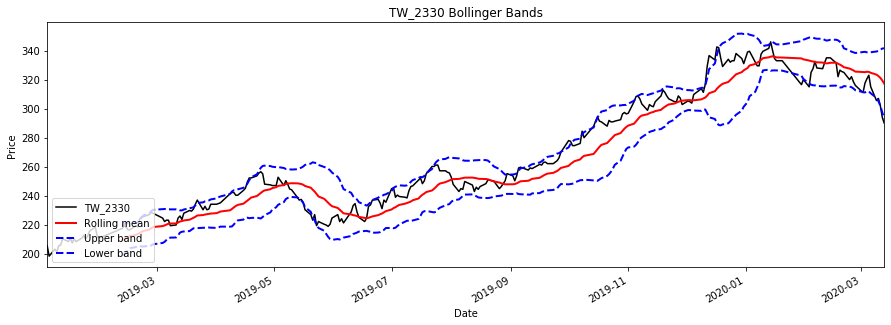

In [4]:
# movie averages (21days)
rm_2330 = prices['TW_2330'].rolling(window = 21, center = False).mean()
rstd_2330 = prices['TW_2330'].rolling(window = 21 , center = False).std()

upper_band = rm_2330 + 2*rstd_2330
lower_band = rm_2330 - 2*rstd_2330

# plot tw_2330 value, rolling mean and Bollinger Bands
plt.figure(figsize = (15, 5))
ax = prices['TW_2330'].plot(title = 'TW_2330 Bollinger Bands', label = 'TW_2330', color='black')
rm_2330.plot(label = 'Rolling mean', ax = ax, color = 'r', linewidth = 2)
upper_band.plot(label = 'Upper band', ax = ax, color = 'b',linewidth = 2 ,style = '--')
lower_band.plot(label = 'Lower band', ax = ax, color = 'b',linewidth = 2 ,style = '--')

# Add axis labels and legends
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc = 'lower left')

## TW 2317

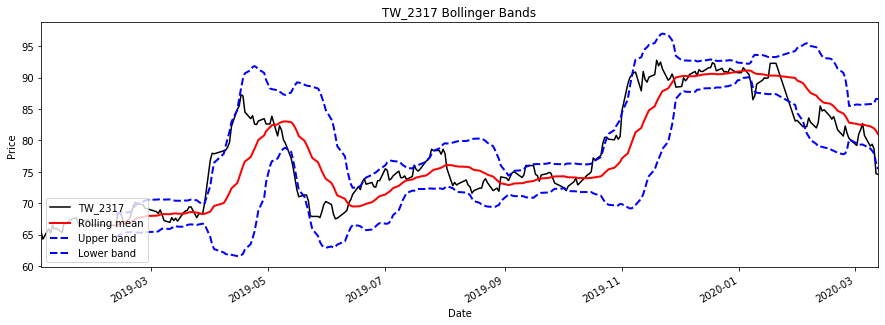

In [5]:
# movie averages (21days)
rm_2317 = prices['TW_2317'].rolling(window = 21, center = False).mean()
rstd_2317 = prices['TW_2317'].rolling(window = 21 , center = False).std()

upper_band = rm_2317 + 2*rstd_2317
lower_band = rm_2317 - 2*rstd_2317

# plot tw_2330 value, rolling mean and Bollinger Bands
plt.figure(figsize = (15, 5))
ax = prices['TW_2317'].plot(title = 'TW_2317 Bollinger Bands', label = 'TW_2317', color='black')
rm_2317.plot(label = 'Rolling mean', ax = ax, color = 'r', linewidth = 2)
upper_band.plot(label = 'Upper band', ax = ax, color = 'b',linewidth = 2 ,style = '--')
lower_band.plot(label = 'Lower band', ax = ax, color = 'b',linewidth = 2 ,style = '--')

# Add axis labels and legends
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc = 'lower left')

# Risk Management

## TW_2330

### 歷史回測法

VaR at 99% :-3.12%
CVaR at 99% :-4.01%


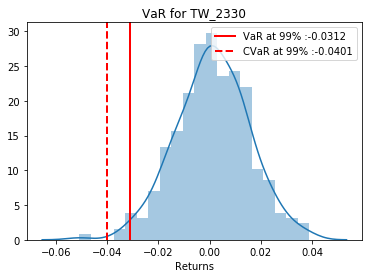

In [6]:
TW2330_ret = returns['TW_2330']

# VaR
var_percentile_99 = TW2330_ret.quantile(0.01)
print('VaR at 99% :{}%'.format(str(round(var_percentile_99*100, 2))))

# CVaR
cvar_99 = TW2330_ret[TW2330_ret <= var_percentile_99].mean()
print('CVaR at 99% :{}%'.format(str(round(cvar_99*100, 2))))

# plot

sns.distplot(TW2330_ret.dropna(), bins=20).set_title('VaR for TW_2330')
plt.xlabel('Returns')
plt.axvline(x=var_percentile_99, color='red', linestyle='-', linewidth=2,
            label='VaR at 99% :{}'.format(str(round(var_percentile_99, 4))))
plt.axvline(x=cvar_99, color='red', linestyle='--', linewidth=2,
            label='CVaR at 99% :{}'.format(str(round(cvar_99, 4))))
plt.legend(loc='upper right')

> 在99%的信心水準下台積電的股票損失不會超過 3.12%。如果台積電的損失超過3.12%的這個條件下，損失的平均值為 4.01%

### 變異數-共變異數法

VaR at 99% :-3.2%
CVaR at 99% :-4.01%


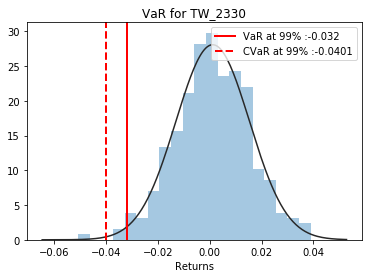

In [7]:
TW2330_ret = returns['TW_2330']

z_01 = -norm.ppf(0.99)
z_01_VaR = z_01*TW2330_ret.std() + TW2330_ret.mean()
print('VaR at 99% :{}%'.format(str(round(z_01_VaR*100, 2))))

z_01_CVaR = TW2330_ret[TW2330_ret <= z_01_VaR].mean()
print('CVaR at 99% :{}%'.format(str(round(z_01_CVaR*100, 2))))

# plot
sns.distplot(TW2330_ret, bins=20, fit=norm,
             kde=False).set_title('VaR for TW_2330')
plt.xlabel('Returns')
plt.axvline(x=z_01_VaR, color='red', linestyle='-', linewidth=2,
            label='VaR at 99% :{}'.format(str(round(z_01_VaR, 4))))
plt.axvline(x=z_01_CVaR, color='red', linestyle='--', linewidth=2,
            label='CVaR at 99% :{}'.format(str(round(z_01_CVaR, 4))))
plt.legend(loc='upper right')

> 在99%的信心水準下台積電的股票損失不會超過 3.2%。如果台積電的損失超過3.12%的這個條件下，損失的平均值為 4.01%

### 蒙地卡羅模擬法

In [8]:
# 蒙地卡羅法
'''
Monte Carlo method
'''
days = 365
dt = 1/days
mu = TW2330_ret.mean()
sigma = TW2330_ret.std()


def stock_monte_carlo(start_price, days, mu, sigma):
    # Define a price array
    price = np.zeros(days)
    price[0] = start_price

    # Shock and Drift
    shock = np.zeros(days)
    drift = np.zeros(days)

    for x in range(1, days):

        # calculate schock, 隨機波動
        shock[x] = np.random.normal(loc=mu*dt, scale=sigma * np.sqrt(dt))
        # calculate drift, 根據收益率波動
        drift[x] = mu*dt
        # calculate price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))

    return price

Text(0.5, 1.0, 'Monte Carlo Analysis for TW2330')

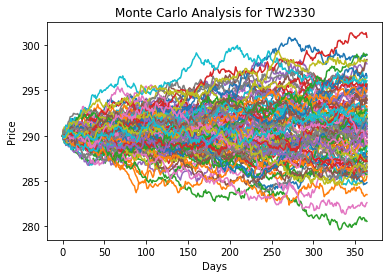

In [9]:
start_price_2330 = prices['TW_2330'][-1]  # 歷史資料的最新交易日 price


for run in range(100):
    plt.plot(stock_monte_carlo(start_price_2330, days, mu, sigma))
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for TW2330')

In [10]:
# set a large number of runs
runs = 10000

# Creat an empty martix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
np.set_printoptions(threshold=5)            # 設定列印出來的 array 長度

for run in range(runs):
    simulations[run] = stock_monte_carlo(
        start_price_2330, days, mu, sigma)[days-1]

Text(0.15, 0.6, 'q(0.99):280.98')

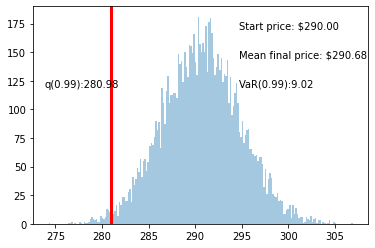

In [11]:
q = np.percentile(simulations, 1)

sns.distplot(simulations, bins=200, kde=False)

#
plt.figtext(0.6, 0.8, s=f'Start price: ${start_price_2330:.2f}')
plt.figtext(0.6, 0.7, s=f'Mean final price: ${simulations.mean():.2f}')
plt.figtext(0.6, 0.6, s=f'VaR(0.99):{start_price_2330 - q:.2f}')

#
plt.axvline(x=q, linewidth=3, color='r')
plt.figtext(0.15, 0.6, f'q(0.99):{q:.2f}')

> 在99%的信心水準下，台積電的股票一年後的價格不會低於281.22元，其風險價值為8.78。在市場正常波動的條件下在未來的一年每張台積電股票的虧損不會高過8.78元

## TW_2317

### 歷史回測法

VaR at 99% :-3.67%
CVaR at 99% :-6.47%


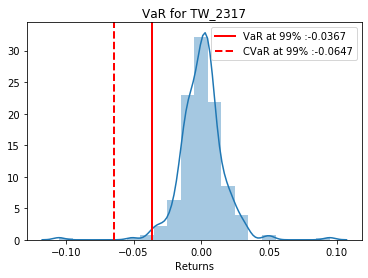

In [12]:
TW2317_ret = returns['TW_2317']

# VaR
var_percentile_99 = TW2317_ret.quantile(0.01)
print('VaR at 99% :{}%'.format(str(round(var_percentile_99*100, 2))))

# CVaR
cvar_99 = TW2317_ret[TW2317_ret <= var_percentile_99].mean()
print('CVaR at 99% :{}%'.format(str(round(cvar_99*100, 2))))

# plot
sns.distplot(TW2317_ret.dropna(), bins=20).set_title('VaR for TW_2317')
plt.xlabel('Returns')
plt.axvline(x=var_percentile_99, color='red', linestyle='-', linewidth=2,
            label='VaR at 99% :{}'.format(str(round(var_percentile_99, 4))))
plt.axvline(x=cvar_99, color='red', linestyle='--', linewidth=2,
            label='CVaR at 99% :{}'.format(str(round(cvar_99, 4))))
plt.legend(loc='upper right')

> 在99%的信心水準下鴻海的股票損失不會超過 3.67%。如果台積電的損失超過3.67%的這個條件下，損失的平均值為 6.47%

### 變異數-共變異數法

VaR at 99% :-3.73%
CVaR at 99% :-6.47%


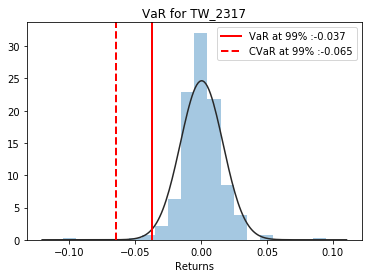

In [13]:
TW2317_ret = returns['TW_2317']

z_01 = -norm.ppf(0.99)
z_01_VaR = z_01*TW2317_ret.std() + TW2317_ret.mean()
print('VaR at 99% :{}%'.format(str(round(z_01_VaR*100, 2))))

z_01_CVaR = TW2317_ret[TW2317_ret <= z_01_VaR].mean()
print('CVaR at 99% :{}%'.format(str(round(z_01_CVaR*100, 2))))

# plot
sns.distplot(TW2317_ret, bins=20, fit=norm,
             kde=False).set_title('VaR for TW_2317')
plt.xlabel('Returns')
plt.axvline(x=z_01_VaR, color='red', linestyle='-', linewidth=2,
            label='VaR at 99% :{}'.format(str(round(z_01_VaR, 3))))
plt.axvline(x=z_01_CVaR, color='red', linestyle='--', linewidth=2,
            label='CVaR at 99% :{}'.format(str(round(z_01_CVaR, 3))))
plt.legend(loc='upper right')

> 在99%的信心水準下鴻海的股票損失不會超過 3.73%。如果台積電的損失超過3.73%的這個條件下，損失的平均值為 6.47%

### 蒙地卡羅模擬法

In [14]:
# 蒙地卡羅法
'''
Monte Carlo method
'''
days = 365
dt = 1/days
mu = TW2317_ret.mean()
sigma = TW2317_ret.std()


def stock_monte_carlo(start_price, days, mu, sigma):
    # Define a price array
    price = np.zeros(days)
    price[0] = start_price

    # Shock and Drift
    shock = np.zeros(days)
    drift = np.zeros(days)

    for x in range(1, days):

        # calculate schock, 隨機波動
        shock[x] = np.random.normal(loc=mu*dt, scale=sigma * np.sqrt(dt))
        # calculate drift, 根據收益率波動
        drift[x] = mu*dt
        # calculate price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))

    return price

Text(0.5, 1.0, 'Monte Carlo Analysis for TW2317')

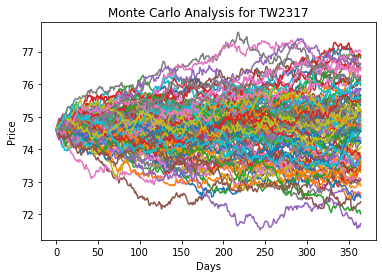

In [15]:
start_price_2317 = prices['TW_2317'][-1]  # 歷史資料的最新交易日 price

for run in range(100):
    plt.plot(stock_monte_carlo(start_price_2317, days, mu, sigma))
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for TW2317')

In [16]:
# set a large number of runs
runs = 10000

# Creat an empty martix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
np.set_printoptions(threshold=5)            # 設定列印出來的 array 長度

for run in range(runs):
    simulations[run] = stock_monte_carlo(
        start_price_2317, days, mu, sigma)[days-1]

Text(0.15, 0.6, 'q(0.99):71.91')

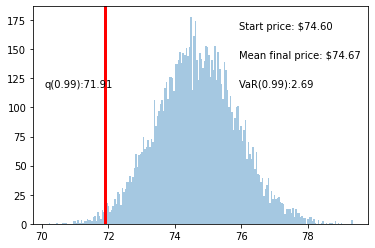

In [17]:
q = np.percentile(simulations, 1)

sns.distplot(simulations, bins=200, kde=False)

#
plt.figtext(0.6, 0.8, s=f'Start price: ${start_price_2317:.2f}')
plt.figtext(0.6, 0.7, s=f'Mean final price: ${simulations.mean():.2f}')
plt.figtext(0.6, 0.6, s=f'VaR(0.99):{start_price_2317 - q:.2f}')

#
plt.axvline(x=q, linewidth=3, color='r')
plt.figtext(0.15, 0.6, f'q(0.99):{q:.2f}')

> 在99%的信心水準下，鴻海的股票一年後的價格不會低於71.83元，其風險價值為2.77。在市場正常波動的條件下在未來的一年每張台積電股票的虧損不會高過2.77元